# **Test Grouping effect of GQA**
In this note book we will attempt to see if after fine tuning there is a connection between W_q matrices that shere the smae head.

In [ ]:
! pip install evaluate transformers==4.52.1 rouge-score nltk
! pip install -U datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
sys.path.append('/content/drive/Transformers/Trasformers/Project')

In [ ]:
from datasets import load_dataset
from evaluate import load

raw_datasets = load_dataset("xsum")
metric = load("rouge")

In [ ]:
raw_datasets["train"] = raw_datasets["train"].shuffle(seed=42).select(range(1000))
raw_datasets["validation"] = raw_datasets["validation"].shuffle(seed=42).select(range(1000))
raw_datasets["test"] = raw_datasets["test"].shuffle(seed=42).select(range(1000))

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "/content/drive/MyDrive/technion/Trasformers/Project/fine_tune_Xsum_6/checkpoint-5000"
model_weights = "/content/drive/MyDrive/technion/Trasformers/Project/fine_tune_Xsum_6/checkpoint-5000/model.safetensors"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
max_input_length = 1024
max_target_length = 128
prefix = "summarize: "

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
import torch
from torch import nn
from safetensors.torch import load_file
from T5_to_GQA import convert_t5_to_gqa, T5GQAAttention
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

sample = tokenized_datasets["validation"][50]

input_ids = torch.tensor(sample["input_ids"]).unsqueeze(0)
attention_mask = torch.tensor(sample["attention_mask"]).unsqueeze(0)

kv_heads = 6
n_heads = 6

# Load the architecture (e.g., google/t5-v1_1-small)
model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-v1_1-small")
convert_t5_to_gqa(model.decoder, kv_heads=kv_heads, inplace=True)

# Load the fine-tuned weights
state_dict = load_file(model_weights)
missing, unexpected = model.load_state_dict(state_dict, strict=False)
model.eval()

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

Missing keys: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
Unexpected keys: []


# **Test clustering of w_q GQA**

In [ ]:
q_outputs = []

def capture_q_hook(module, input, output):
    # input[0] shape - (batch, seq_len, d_model)
    hidden_states = input[0]
    q = torch.nn.functional.linear(hidden_states, module.q.weight, module.q.bias if module.q.bias is not None else None)
    q_outputs.append(q.detach())

hooks = []
def register_hooks(module):
    if isinstance(module, OPTGQAAttention):
        hooks.append(module.register_forward_hook(capture_q_hook))
for name, module in model.decoder.named_modules():
    register_hooks(module)

with torch.no_grad():
    model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=input_ids)

for h in hooks:
    h.remove()

d_kv = q_outputs[0].shape[2] // n_heads
print(f"Captured {len(q_outputs)} layers of q projections")

for idx in range(len(q_outputs)):
  q_outputs[idx] = q_outputs[idx].view(q_outputs[idx].shape[0], -1, n_heads, d_kv).transpose(1, 2)

print("Shape of first q projection:", q_outputs[0].shape)  # (1, num_heads, seq_len, head_dim)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Captured 16 layers of q projections
Shape of first q projection: torch.Size([1, 6, 419, 64])


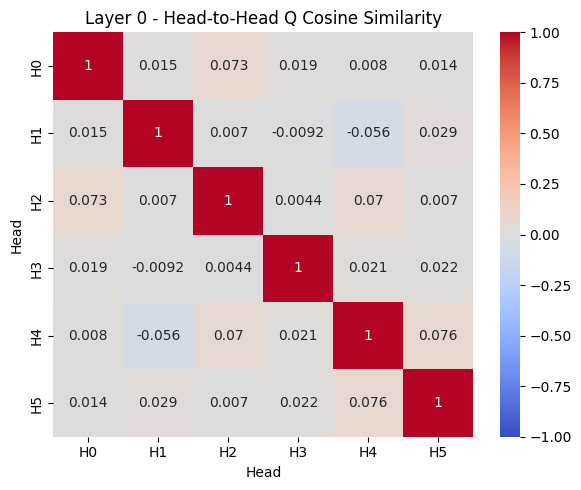

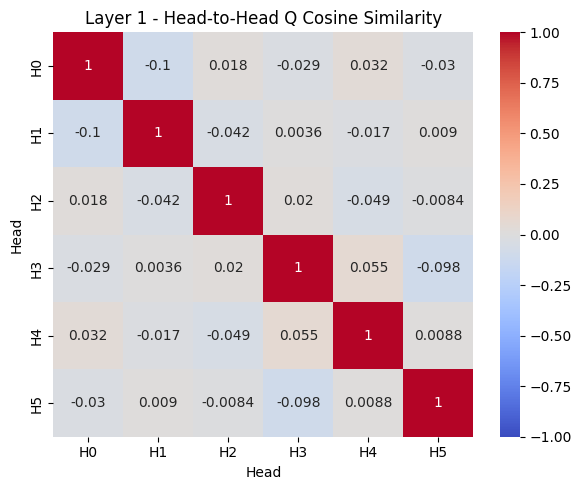

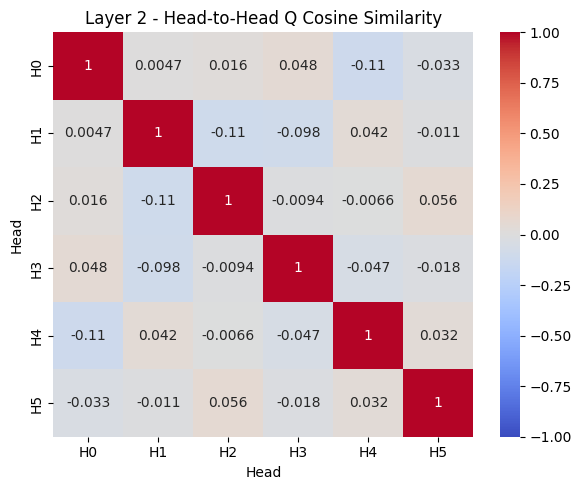

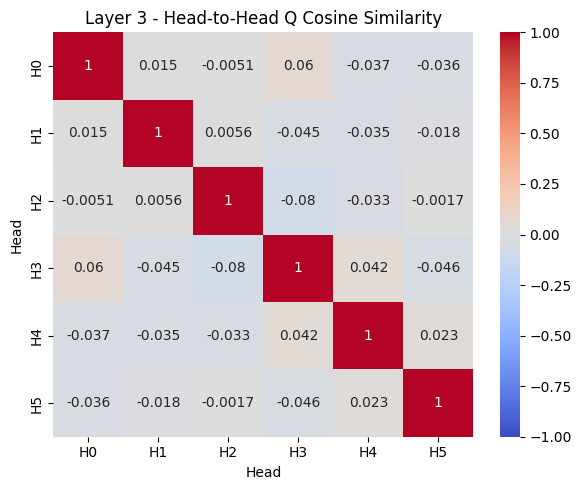

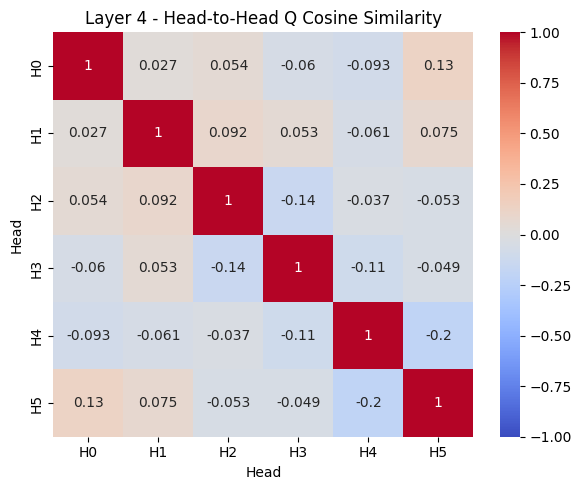

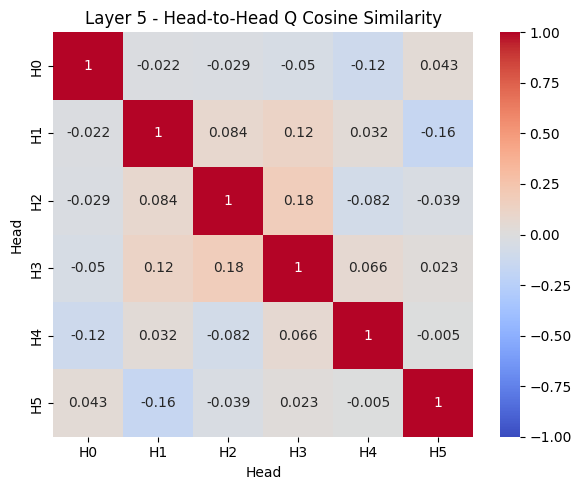

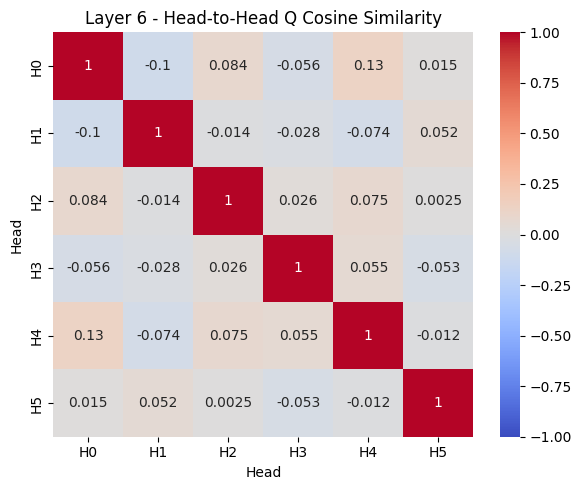

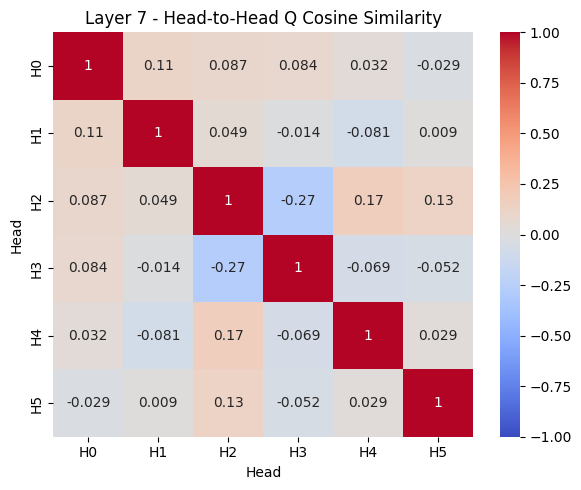

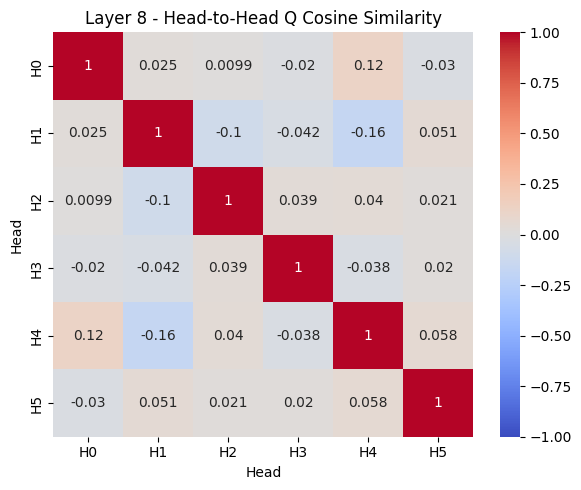

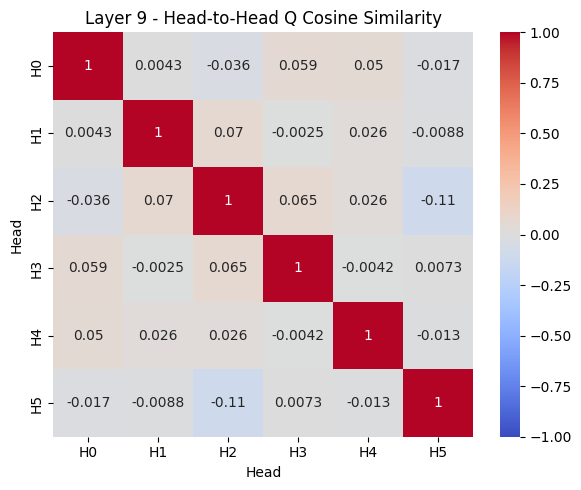

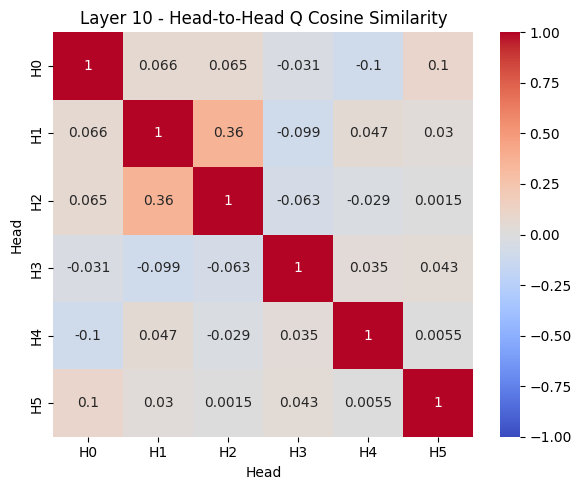

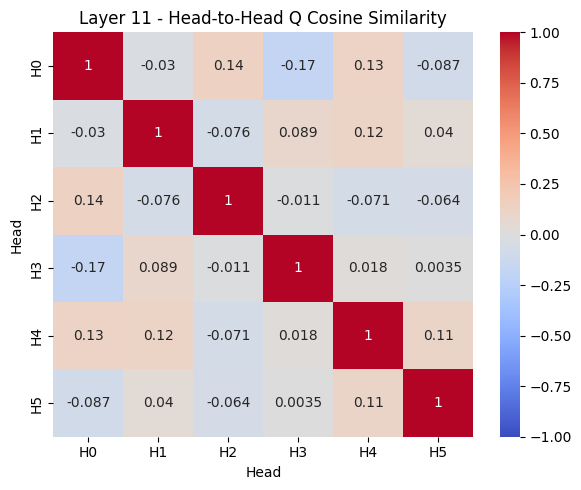

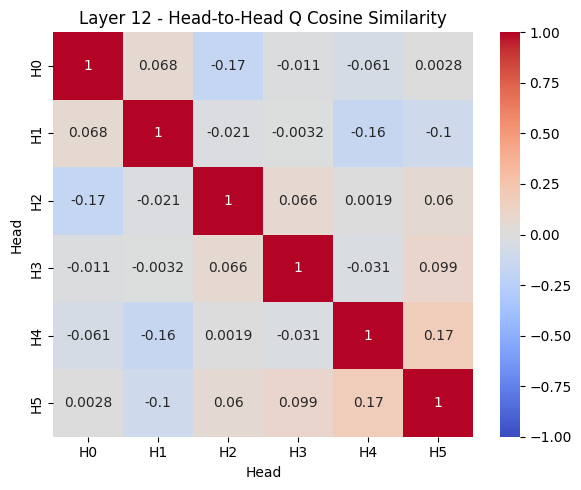

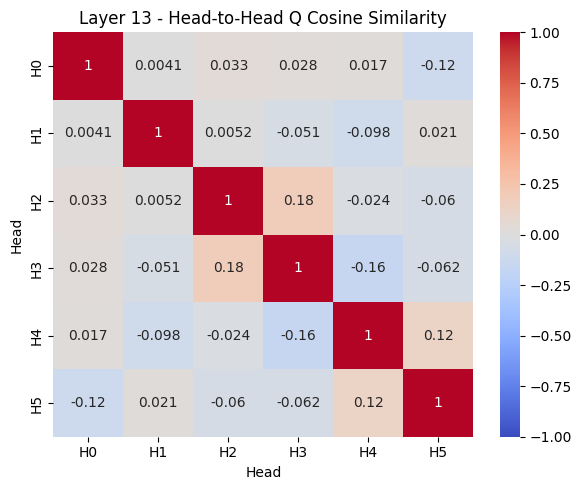

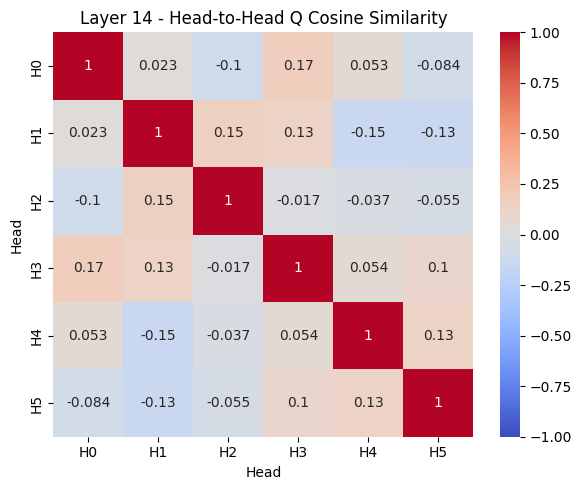

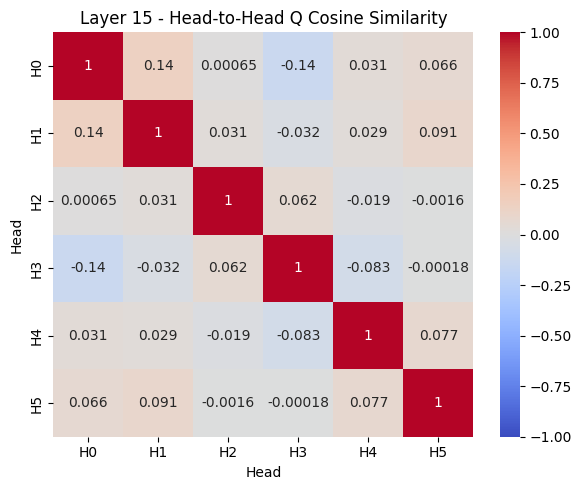

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

def plot_layer_head_similarity(q_outputs):
    for layer_idx, q_proj in enumerate(q_outputs):
        q_proj = q_proj.squeeze(0)  # (n_heads, seq_len, d_kv)
        n_heads, seq_len, d_kv = q_proj.shape

        sim_matrix = torch.zeros((n_heads, n_heads))

        for t in range(seq_len):
            q_vectors = q_proj[:, t, :]  # (n_heads, d_kv)
            q_norm = F.normalize(q_vectors, dim=1)  # normalize each head's vector

            cos_sim = torch.matmul(q_norm, q_norm.T)  # → (n_heads, n_heads)
            sim_matrix += cos_sim

        # Average across sequence length
        sim_matrix /= seq_len
        sim_matrix_np = sim_matrix.cpu().numpy()

        plt.figure(figsize=(6, 5))
        sns.heatmap(sim_matrix_np, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
                    xticklabels=[f"H{i}" for i in range(n_heads)],
                    yticklabels=[f"H{i}" for i in range(n_heads)])
        plt.title(f"Layer {layer_idx} - Head-to-Head Q Cosine Similarity")
        plt.xlabel("Head")
        plt.ylabel("Head")
        plt.tight_layout()
        plt.show()

plot_layer_head_similarity(q_outputs)

# **Check if model was loaded correctly**

In [ ]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from transformers import TrainerCallback
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    result = {key: value * 100 for key, value in result.items()}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
batch_size = 8
args = Seq2SeqTrainingArguments(
    output_dir=f"/content/drive/MyDrive/technion/Trasformers/Project/fine_tune_Xsum_{kv_heads}",
    eval_strategy = "epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=1,
    logging_dir="/content/drive/MyDrive/technion/Trasformers/Project/logs",
    logging_steps=100,
    predict_with_generate=True,
    report_to="none"
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

test_results = trainer.predict(tokenized_datasets["test"].select(range(50)))

# Print ROUGE-1 (and optionally others)
print("Test set ROUGE scores:")
print(f"ROUGE-1: {test_results.metrics['test_rouge1']:.2f}")

/tmp/ipython-input-35-1125579252.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Test set ROUGE scores:
ROUGE-1: 21.71
